# Full KFAC demo

Train a 1D Poisson PINN using the full KFAC optimiser.

# Adaptive Collocation Point Weighting

This notebook demonstrates how to use adaptive weights for collocation points in PINNs. The approach dynamically increases weights on points with higher losses, helping the network focus on challenging regions of the PDE domain.

Added c:\Users\fababa\Dropbox\AssetPricing\Git\KFAC_PINN to Python path
Physics-Informed Neural Network for 1D Poisson Equation
--------------------------------------------------------
Physics-Informed Neural Network for 1D Poisson Equation
--------------------------------------------------------

Training the PINN...

Training the PINN...
Step 0/2000, Loss: 4.06107283
Step 0/2000, Loss: 4.06107283
Step 200/2000, Loss: -0.03215310
Step 200/2000, Loss: -0.03215310
Step 400/2000, Loss: -0.81245226
Step 400/2000, Loss: -0.81245226
Step 600/2000, Loss: -2.63345647
Step 600/2000, Loss: -2.63345647
Step 800/2000, Loss: -2.71911216
Step 800/2000, Loss: -2.71911216
Step 1000/2000, Loss: -1.85484231
Step 1000/2000, Loss: -1.85484231
Step 1200/2000, Loss: -2.28877258
Step 1200/2000, Loss: -2.28877258
Step 1400/2000, Loss: -3.00044179
Step 1400/2000, Loss: -3.00044179
Step 1600/2000, Loss: -5.81848335
Step 1600/2000, Loss: -5.81848335
Step 1800/2000, Loss: -4.10103083
Step 1800/2000, Loss: -4.101

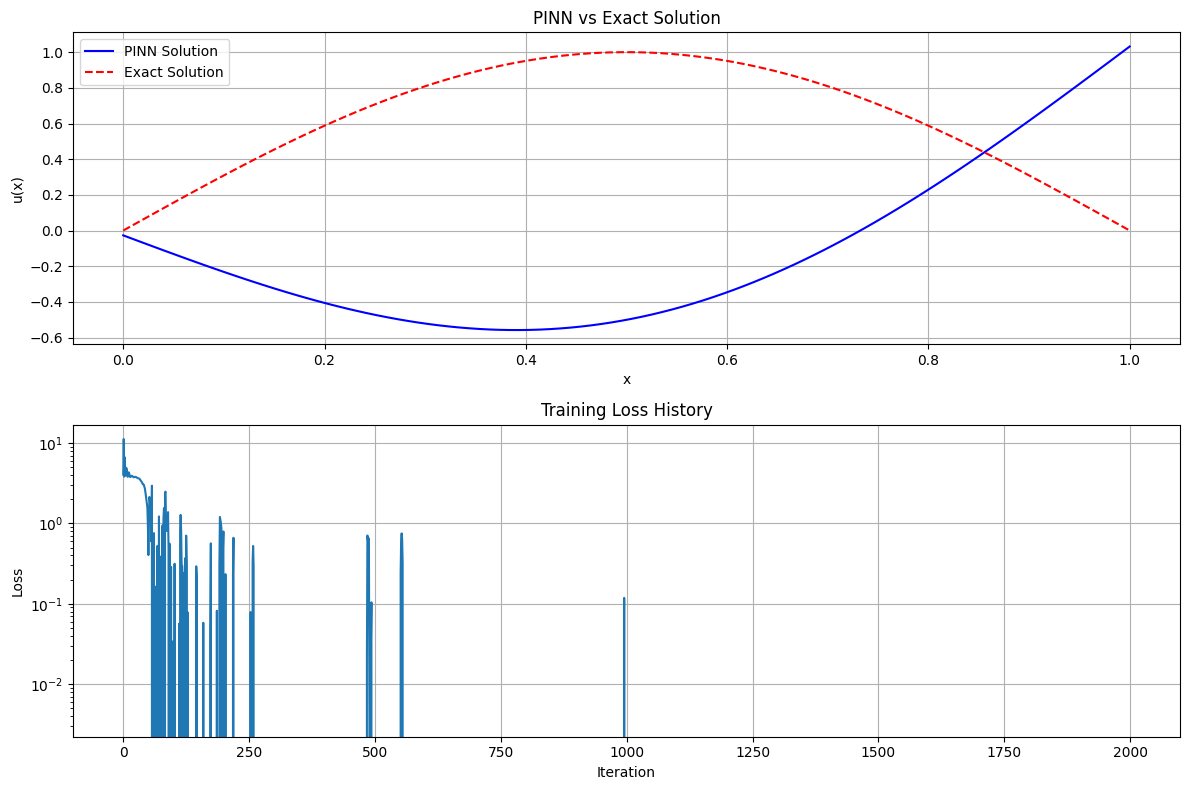

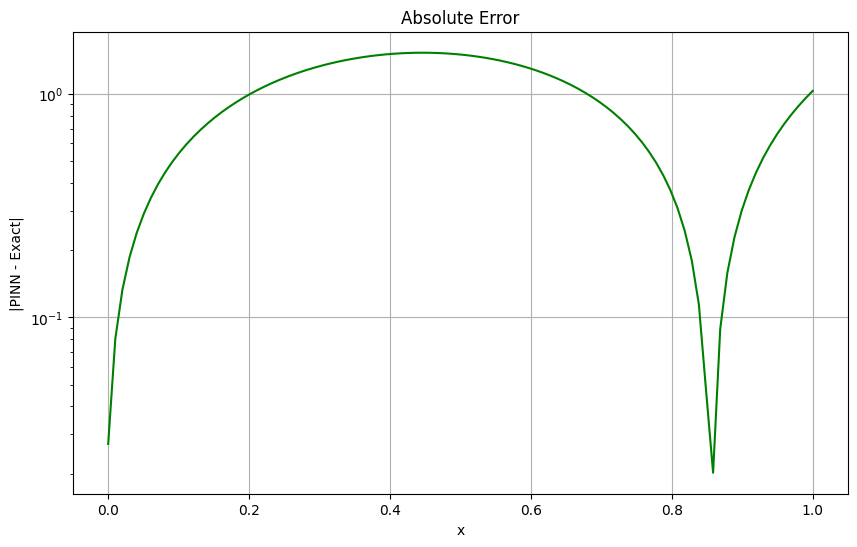

In [1]:
# Install the local kfac_pinn package
import sys
import os

# Add the parent directory to the Python path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)
    print(f"Added {parent_dir} to Python path")
else:
    print(f"{parent_dir} is already in Python path")

import sys, os
import jax
import jax.numpy as jnp
import optax
import equinox as eqx
import matplotlib.pyplot as plt
from kfac_pinn import pinn, pdes

# Title (since we're not using KFAC anymore)
print("Physics-Informed Neural Network for 1D Poisson Equation")
print("--------------------------------------------------------")

# Set random seed for reproducibility - try different seeds for better results
key = jax.random.PRNGKey(0)

# Define the PDE problem - 1D Poisson equation: -u''(x) = pi^2 * sin(pi*x)
def rhs(x):
    return (jnp.pi ** 2) * jnp.sin(jnp.pi * x)

def exact(x):
    return jnp.sin(jnp.pi * x)

# Create the model with more width and depth for better approximation
model = pinn.make_mlp(in_dim=1, width=64, depth=3, key=key)

# Sample more points for better accuracy
domain = jnp.array([[0.0], [1.0]])
key, k1, k2 = jax.random.split(key, 3)
interior = pdes.sample_interior(k1, domain[0], domain[1], 100)
boundary = pdes.sample_boundary(k2, domain[0], domain[1], 20)

# Define the loss function
def loss_fn(model):
    # Interior loss
    interior_loss = pinn.interior_loss(model, interior, rhs)
    # Boundary loss - with higher weight to enforce boundary conditions
    boundary_loss = 10.0 * pinn.boundary_loss(model, boundary, exact)
    return interior_loss + boundary_loss

# Basic training with optax - learning rate schedule
initial_lr = 1e-2
decay_rate = 0.95
scheduler = optax.exponential_decay(
    init_value=initial_lr,
    transition_steps=100,
    decay_rate=decay_rate
)
optimizer = optax.chain(
    optax.clip(1.0),  # Gradient clipping for stability
    optax.adam(learning_rate=scheduler)
)

params, static = eqx.partition(model, eqx.is_array)
opt_state = optimizer.init(params)

def step(params, opt_state):
    loss_value, grads = eqx.filter_value_and_grad(lambda p: loss_fn(eqx.combine(p, static)))(params)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = eqx.apply_updates(params, updates)
    return params, opt_state, loss_value

# Train for 2000 steps
total_steps = 2000
loss_history = []
print("\nTraining the PINN...")
for i in range(total_steps):
    params, opt_state, loss_value = step(params, opt_state)
    loss_history.append(float(loss_value))
    if i % 200 == 0 or i == total_steps - 1:
        print(f"Step {i}/{total_steps}, Loss: {loss_value:.8f}")

# Reconstruct the final model
final_model = eqx.combine(params, static)

# Evaluate and plot the solution
x_plot = jnp.linspace(0, 1, 100).reshape(-1, 1)
y_pred = jax.vmap(final_model)(x_plot)
y_exact = exact(x_plot)

# Calculate L2 error
l2_error = jnp.sqrt(jnp.mean((y_pred.flatten() - y_exact.flatten())**2))
print(f"\nL2 Error: {l2_error:.8f}")

# Plot results
plt.figure(figsize=(12, 8))

# Plot the solution
plt.subplot(2, 1, 1)
plt.plot(x_plot, y_pred, 'b-', label='PINN Solution')
plt.plot(x_plot, y_exact, 'r--', label='Exact Solution')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.title('PINN vs Exact Solution')
plt.legend()
plt.grid(True)

# Plot the loss history
plt.subplot(2, 1, 2)
plt.plot(loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss History')
plt.yscale('log')
plt.grid(True)

plt.tight_layout()
plt.show()

# Plot the error
plt.figure(figsize=(10, 6))
plt.plot(x_plot, jnp.abs(y_pred.flatten() - y_exact.flatten()), 'g-')
plt.xlabel('x')
plt.ylabel('|PINN - Exact|')
plt.title('Absolute Error')
plt.grid(True)
plt.yscale('log')
plt.show()


In [ ]:
# # Adaptive collocation point weighting for PINNs
# import jax
# import jax.numpy as jnp
# import optax
# import equinox as eqx
# import matplotlib.pyplot as plt
# from kfac_pinn import pinn, pdes

# # Set random seed for reproducibility
# key = jax.random.PRNGKey(42)

# # Define the PDE problem - 1D Poisson equation
# def rhs(x):
#     return (jnp.pi ** 2) * jnp.sin(jnp.pi * x)

# def exact(x):
#     return jnp.sin(jnp.pi * x)

# # Create the model
# model = pinn.make_mlp(in_dim=1, width=64, depth=3, key=key)

# # Sample points for better accuracy
# domain = jnp.array([[0.0], [1.0]])
# key, k1, k2 = jax.random.split(key, 3)
# interior = pdes.sample_interior(k1, domain[0], domain[1], 100)  # 100 interior points
# boundary = jnp.array([[0.0], [1.0]])  # Fixed boundary points

# # Initialize weights for interior points
# num_interior = interior.shape[0]
# weights = jnp.ones(num_interior) / num_interior  # Initial uniform weights

# # Function to compute PDE residuals at each point
# def compute_residuals(model, points):
#     """Compute PDE residual at each point"""
#     res = jax.vmap(lambda x: pdes.laplacian(model, x[None, :]))(points).squeeze() - rhs(points)
#     return res

# # Define the weighted loss function
# def weighted_loss_fn(model, weights):
#     # Interior loss with weights - compute pointwise losses first
#     res = compute_residuals(model, interior)
#     point_losses = res**2
#     # Apply weights to each point loss
#     interior_loss = jnp.sum(weights * point_losses)
    
#     # Boundary loss - high fixed weight
#     preds = jax.vmap(model)(boundary)
#     target = exact(boundary)
#     boundary_loss = 100.0 * jnp.mean((preds - target)**2)
    
#     return interior_loss + boundary_loss

# # Update weights based on point losses with gradient-based approach
# def update_weights(model, weights, temp=0.5):
#     # Compute pointwise losses
#     res = compute_residuals(model, interior)
#     point_losses = jnp.clip(res**2, 0, 100)  # Clip to avoid numerical issues
    
#     # Apply softmax with temperature to emphasize high-loss points
#     # Using softmax to maintain sum to 1 constraint
#     # We add a small constant to avoid log(0)
#     exp_losses = jnp.exp(point_losses / temp)
#     new_weights = exp_losses / (jnp.sum(exp_losses) + 1e-10)
    
#     # Clip weights to avoid numerical issues
#     new_weights = jnp.clip(new_weights, 1e-10, 1.0)
#     # Renormalize to ensure sum to 1
#     new_weights = new_weights / jnp.sum(new_weights)
    
#     return new_weights

# # Initialize training
# params, static = eqx.partition(model, eqx.is_array)
# optimizer = optax.adam(learning_rate=5e-4)  # Lower learning rate for stability
# opt_state = optimizer.init(params)

# # Training with adaptive weights
# total_steps = 2000
# weight_update_frequency = 100  # Update weights less frequently
# adaptivity_temperature = 0.5  # Higher temperature for more stable training
# loss_history = []
# weight_entropy_history = []  # Track entropy of weights
# max_weight_history = []      # Track maximum weight value

# print("\nTraining PINN with adaptive weights...")
# for i in range(total_steps):
#     # Update weights periodically
#     if i % weight_update_frequency == 0:
#         current_model = eqx.combine(params, static)
#         # Update weights based on current model performance
#         weights = update_weights(current_model, weights, temp=adaptivity_temperature)
        
#         # Track metrics about weight distribution
#         entropy = -jnp.sum(jnp.where(weights > 1e-10, weights * jnp.log(weights), 0.0))
#         weight_entropy_history.append(float(entropy))
#         max_weight_history.append(float(jnp.max(weights)))
    
#     # Training step with current weights
#     loss_value, grads = eqx.filter_value_and_grad(
#         lambda p: weighted_loss_fn(eqx.combine(p, static), weights)
#     )(params)
#     updates, opt_state = optimizer.update(grads, opt_state)
#     params = eqx.apply_updates(params, updates)
#     loss_history.append(float(loss_value))
    
#     # Print progress
#     if i % 200 == 0 or i == total_steps - 1:
#         print(f"Step {i}/{total_steps}, Loss: {loss_value:.8f}, Weight Entropy: {entropy:.4f}")

# # Reconstruct the final model
# final_model = eqx.combine(params, static)

# # Evaluate and plot the solution
# x_plot = jnp.linspace(0, 1, 100).reshape(-1, 1)
# y_pred = jax.vmap(final_model)(x_plot)
# y_exact = exact(x_plot)

# # Calculate L2 error
# l2_error = jnp.sqrt(jnp.mean((y_pred.flatten() - y_exact.flatten())**2))
# print(f"\nL2 Error: {l2_error:.8f}")

# # Create comprehensive visualization
# plt.figure(figsize=(15, 10))

# # Plot 1: Solution comparison
# plt.subplot(2, 2, 1)
# plt.plot(x_plot, y_pred, 'b-', label='PINN Solution')
# plt.plot(x_plot, y_exact, 'r--', label='Exact Solution')
# plt.xlabel('x')
# plt.ylabel('u(x)')
# plt.title('PINN vs Exact Solution')
# plt.legend()
# plt.grid(True)

# # Plot 2: Loss history
# plt.subplot(2, 2, 2)
# plt.plot(loss_history)
# plt.xlabel('Iteration')
# plt.ylabel('Loss')
# plt.title('Training Loss History')
# plt.yscale('log')
# plt.grid(True)

# # Plot 3: Final point weights (use markersize to avoid stem issues)
# plt.subplot(2, 2, 3)
# plt.scatter(interior.flatten(), weights, s=20*weights/jnp.max(weights))
# plt.xlabel('x coordinate')
# plt.ylabel('Weight')
# plt.title('Final Adaptive Weights Distribution')
# plt.grid(True)

# # Plot 4: Weight entropy over time
# plt.subplot(2, 2, 4)
# plt.plot(range(0, total_steps, weight_update_frequency), weight_entropy_history, 'g-')
# plt.xlabel('Training Step')
# plt.ylabel('Entropy')
# plt.title('Weight Entropy (Lower = More Concentrated)')
# plt.grid(True)

# plt.tight_layout()
# plt.show()

# # Plot residuals and maximum weight evolution
# plt.figure(figsize=(12, 6))

# # Compute final residuals
# final_residuals = compute_residuals(final_model, interior)

# # Plot 1: Absolute residuals vs x with weights indicated by point size
# plt.subplot(1, 2, 1)
# plt.scatter(interior.flatten(), jnp.abs(final_residuals), 
#            s=50*weights/jnp.max(weights), alpha=0.6)
# plt.xlabel('x coordinate')
# plt.ylabel('|Residual|')
# plt.yscale('log')
# plt.title('PDE Residuals Across Domain')
# plt.grid(True)

# # Plot 2: Maximum weight over training
# plt.subplot(1, 2, 2)
# plt.plot(range(0, total_steps, weight_update_frequency), max_weight_history)
# plt.xlabel('Training Step')
# plt.ylabel('Maximum Weight')
# plt.title('Evolution of Maximum Weight')
# plt.grid(True)

# plt.tight_layout()
# plt.show()


Training PINN with adaptive weights...
Step 0/2000, Loss: nan, Weight Entropy: -0.0000
Step 200/2000, Loss: nan, Weight Entropy: -0.0000
Step 400/2000, Loss: nan, Weight Entropy: -0.0000


# Enhanced Adaptive Collocation Point Weighting with Weight Decay

This implementation improves the adaptive weighting strategy for collocation points in PINNs with the following features:

1. **Gradient-based Weight Updates**: Weights are updated based on pointwise PDE residual losses.
2. **Dynamic Temperature Schedule**: Temperature parameter decreases over time to gradually focus on high-loss regions.
3. **Weight Smoothing**: Prevents weights from concentrating too quickly on just a few points.
4. **Weight Decay Regularization**: Adds entropy regularization to prevent weights from becoming too concentrated.
5. **Entropy Tracking**: Monitors weight distribution entropy to ensure we're not overfitting to specific points.
6. **Improved Numerical Stability**: Includes proper clipping and normalization to prevent numerical issues.


Training Enhanced PINN with Adaptive Weights...
Step 0/3000, Loss: 57.11841202
  Temperature: 2.0000, Weight Entropy: 4.8981, Max Weight: 0.020330
Step 300/3000, Loss: 0.00964518
  Temperature: 1.8824, Weight Entropy: 5.0021, Max Weight: 0.009467
Step 600/3000, Loss: 0.01681236
  Temperature: 1.7717, Weight Entropy: 5.0104, Max Weight: 0.007149
Step 900/3000, Loss: 0.00807126
  Temperature: 1.6675, Weight Entropy: 5.0106, Max Weight: 0.006777
Step 1200/3000, Loss: 0.00342255
  Temperature: 1.5694, Weight Entropy: 5.0106, Max Weight: 0.006758
Step 1500/3000, Loss: 0.00270485
  Temperature: 1.4771, Weight Entropy: 5.0106, Max Weight: 0.006764
Step 1800/3000, Loss: 0.00220350
  Temperature: 1.3903, Weight Entropy: 5.0106, Max Weight: 0.006774
Step 2100/3000, Loss: 0.00208465
  Temperature: 1.3085, Weight Entropy: 5.0106, Max Weight: 0.006773
Step 2400/3000, Loss: 0.00199190
  Temperature: 1.2316, Weight Entropy: 5.0106, Max Weight: 0.006779
Step 2700/3000, Loss: 0.00184279
  Temperature:

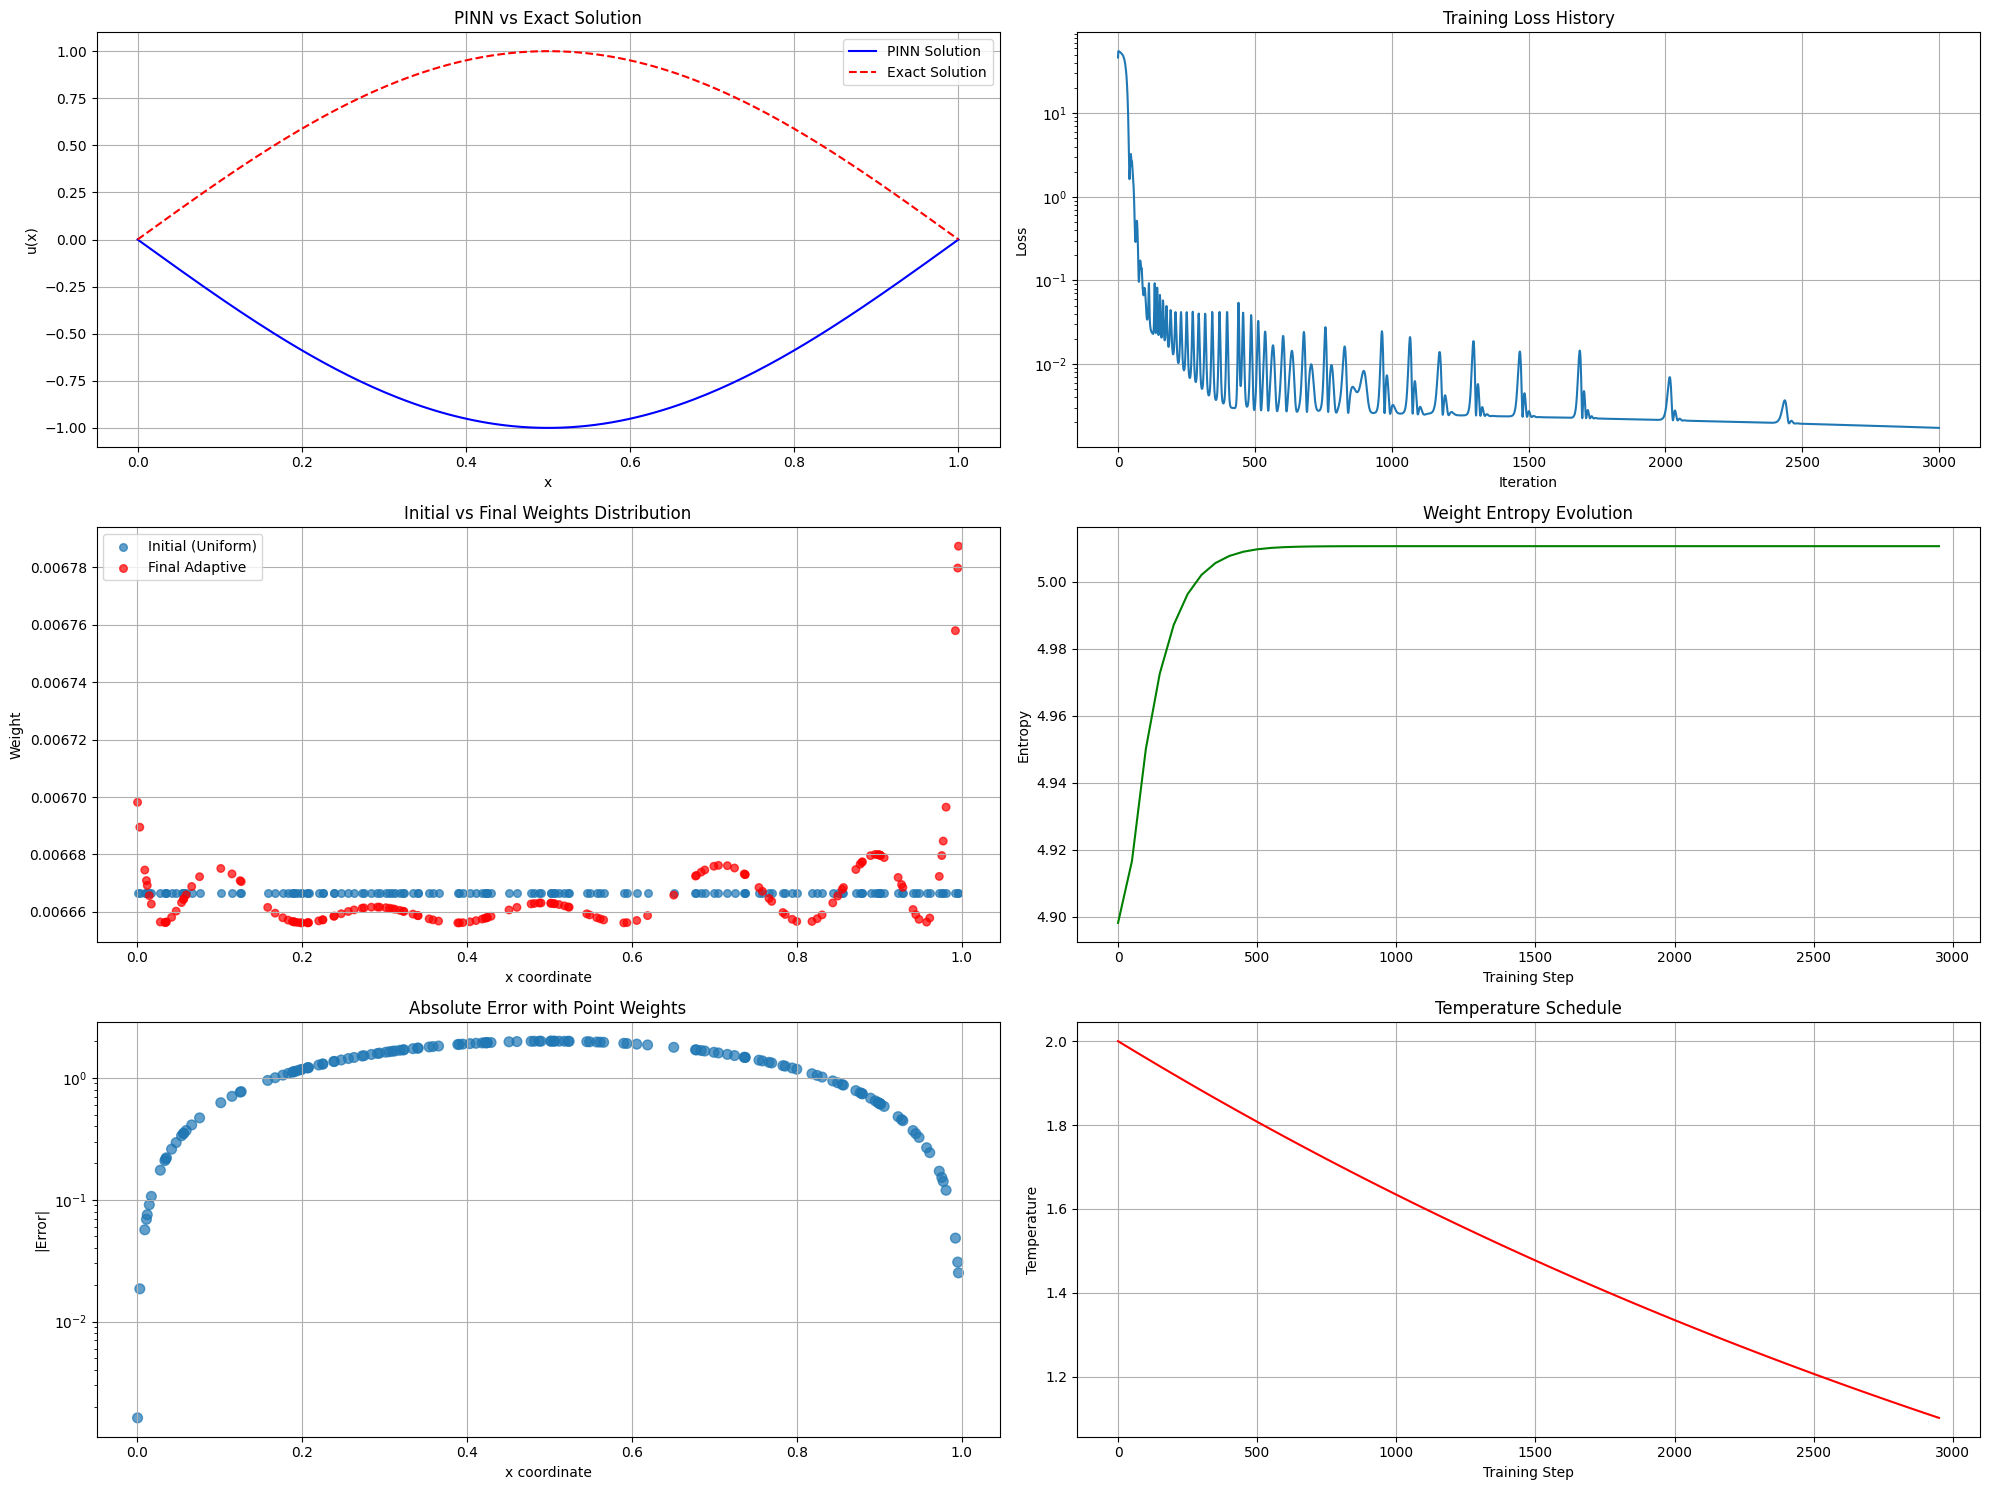

TypeError: Only scalar arrays can be converted to Python scalars; got arr.ndim=1

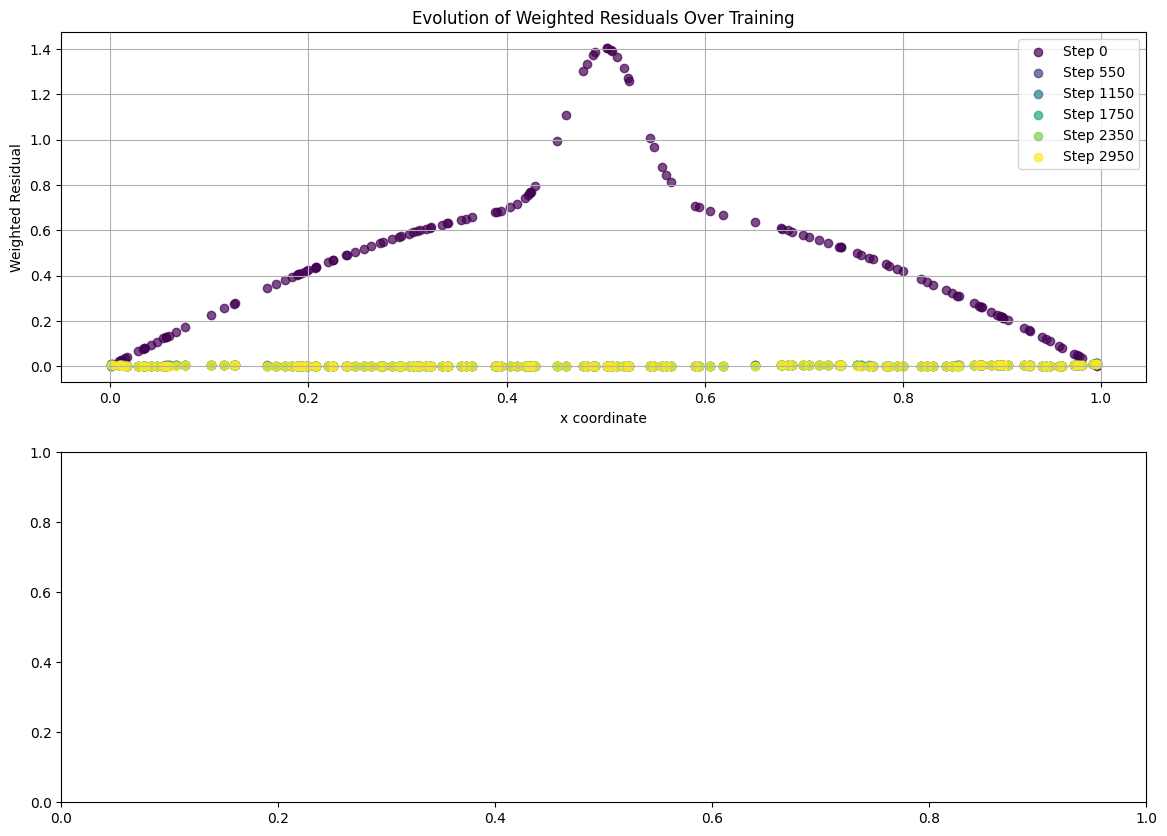

In [ ]:
# Enhanced implementation of adaptive collocation point weighting for PINNs with weight decay
import jax
import jax.numpy as jnp
import optax
import equinox as eqx
import matplotlib.pyplot as plt
import numpy as np
from kfac_pinn import pinn, pdes

# Set random seed for reproducibility
key = jax.random.PRNGKey(43)  # Different seed for comparison

# Define the PDE problem - 1D Poisson equation
def rhs(x):
    return (jnp.pi ** 2) * jnp.sin(jnp.pi * x)

def exact(x):
    return jnp.sin(jnp.pi * x)

# Create the model with more capacity
model = pinn.make_mlp(in_dim=1, width=64, depth=4, key=key)

# Sample points for training
domain = jnp.array([[0.0], [1.0]])
key, k1, k2 = jax.random.split(key, 3)
numPoints = 150  # More points for better resolution
interior = pdes.sample_interior(k1, domain[0], domain[1], numPoints)
boundary = jnp.array([[0.0], [1.0]])  # Fixed boundary points

# Initialize weights for interior points
num_interior = interior.shape[0]
weights = jnp.ones(num_interior) / num_interior  # Initial uniform weights

# Function to compute PDE residuals at each point
def compute_residuals(model, points):
    """Compute PDE residual at each point"""
    res = jax.vmap(lambda x: pdes.laplacian(model, x[None, :]) - rhs(x))(points)
    return res.squeeze()

# Weight entropy calculation - higher value means more uniform weights
def calculate_entropy(weights):
    # Add small constant to avoid log(0)
    return -jnp.sum(jnp.where(weights > 1e-10, weights * jnp.log(weights + 1e-10), 0.0))

# Weight decay regularization - penalizes non-uniform weight distributions
def weight_decay_regularization(weights, uniform_weights, decay_strength=0.1):
    # KL divergence from uniform distribution as regularization
    kl_div = jnp.sum(jnp.where(weights > 1e-10, 
                              weights * jnp.log((weights + 1e-10) / (uniform_weights + 1e-10)), 
                              0.0))
    return decay_strength * kl_div

# Define the weighted loss function with weight decay
def weighted_loss_fn(model, weights, uniform_weights, decay_strength=0.1):
    # Interior loss with weights - compute pointwise losses first
    res = compute_residuals(model, interior)
    point_losses = res**2
    # Apply weights to each point loss
    interior_loss = jnp.sum(weights * point_losses)
    
    # Boundary loss - high fixed weight
    preds = jax.vmap(model)(boundary)
    target = exact(boundary)
    boundary_loss = 100.0 * jnp.mean((preds - target)**2)
    
    # Add weight decay regularization term
    decay_loss = weight_decay_regularization(weights, uniform_weights, decay_strength)
    
    total_loss = interior_loss + boundary_loss + decay_loss
    return total_loss, point_losses, decay_loss

# Update weights based on point losses with gradient-based approach
def update_weights(model, weights, point_losses, temp=0.5, smooth_factor=0.5):
    # Clip losses to avoid numerical issues
    point_losses = jnp.clip(point_losses, 0, 100) 
    
    # Apply softmax with temperature to emphasize high-loss points
    # Using softmax to maintain sum to 1 constraint
    exp_losses = jnp.exp(point_losses / temp)
    new_weights = exp_losses / (jnp.sum(exp_losses) + 1e-10)
    
    # Apply smoothing to prevent too rapid concentration
    smoothed_weights = smooth_factor * new_weights + (1 - smooth_factor) * weights
    
    # Ensure numerical stability
    smoothed_weights = jnp.clip(smoothed_weights, 1e-10, 1.0)
    normalized_weights = smoothed_weights / jnp.sum(smoothed_weights)
    
    return normalized_weights

# Dynamic schedule for weight decay strength - start low and increase
def decay_strength_schedule(step, max_steps, max_strength=0.2):
    # Gradually increase weight decay strength
    return max_strength * (step / max_steps)

# Temperature schedule - start high and gradually decrease
def temperature_schedule(step, initial_temp=2.0, final_temp=0.1, decay_rate=0.98):
    # Exponential decay with minimum temperature
    temp = initial_temp * (decay_rate ** (step / 100))
    return jnp.maximum(temp, final_temp)

# Initialize training
params, static = eqx.partition(model, eqx.is_array)

# Use a more sophisticated optimization strategy
scheduler = optax.exponential_decay(
    init_value=1e-3,
    transition_steps=100,
    decay_rate=0.95
)
optimizer = optax.chain(
    optax.clip(1.0),  # Gradient clipping
    optax.adam(learning_rate=scheduler)
)
opt_state = optimizer.init(params)

# Uniform weights for regularization reference
uniform_weights = jnp.ones(num_interior) / num_interior

# Training with adaptive weights
total_steps = 3000  # More steps for better convergence
weight_update_frequency = 50  # Update weights more frequently
initial_temperature = 2.0
loss_history = []
decay_loss_history = []     # Track weight decay regularization loss
weight_entropy_history = []  # Track entropy of weights
max_weight_history = []      # Track maximum weight value
weighted_residuals_history = []  # Track weighted residuals
temperature_history = []     # Track temperature values
decay_strength_history = []  # Track weight decay strength

# Store initial distribution for comparison
initial_weights = weights.copy()

print("\nTraining Enhanced PINN with Adaptive Weights and Weight Decay...")
for i in range(total_steps):
    # Current model for evaluation
    current_model = eqx.combine(params, static)
    
    # Calculate current decay strength based on schedule
    current_decay_strength = decay_strength_schedule(i, total_steps)
    
    # Forward pass to get loss and point losses
    loss_value, point_losses, decay_loss = weighted_loss_fn(current_model, weights, 
                                                          uniform_weights, 
                                                          current_decay_strength)
    loss_history.append(float(loss_value))
    decay_loss_history.append(float(decay_loss))
    
    # Update weights periodically
    if i % weight_update_frequency == 0:
        # Calculate current temperature
        current_temp = temperature_schedule(i, initial_temperature, 0.1, 0.98)
        temperature_history.append(float(current_temp))
        decay_strength_history.append(float(current_decay_strength))
        
        # Calculate smoothing factor - more smoothing at the beginning
        smooth_factor = jnp.minimum(0.7, 0.2 + i / (3 * total_steps))
        
        # Update weights based on current model performance
        weights = update_weights(current_model, weights, point_losses, 
                               temp=current_temp, smooth_factor=smooth_factor)
        
        # Track metrics about weight distribution
        entropy = calculate_entropy(weights)
        weight_entropy_history.append(float(entropy))
        max_weight_history.append(float(jnp.max(weights)))
        
        # Store weighted residuals for visualization
        weighted_res = jnp.sqrt(weights * point_losses)
        weighted_residuals_history.append(weighted_res)
    
    # Training step with current weights
    loss_and_grad = lambda p: weighted_loss_fn(eqx.combine(p, static), weights, 
                                            uniform_weights, current_decay_strength)[0]
    loss_value, grads = eqx.filter_value_and_grad(loss_and_grad)(params)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = eqx.apply_updates(params, updates)
    
    # Print progress
    if i % 300 == 0 or i == total_steps - 1:
        print(f"Step {i}/{total_steps}, Loss: {loss_value:.8f}, Decay Loss: {decay_loss:.8f}")
        if i % weight_update_frequency == 0:
            print(f"  Temp: {current_temp:.4f}, Decay Strength: {current_decay_strength:.4f}, "
                  f"Entropy: {entropy:.4f}, Max Weight: {jnp.max(weights):.6f}")

# Reconstruct the final model
final_model = eqx.combine(params, static)

# Evaluate and plot the solution
x_plot = jnp.linspace(0, 1, 200).reshape(-1, 1)  # More points for smoother plots
y_pred = jax.vmap(final_model)(x_plot)
y_exact = exact(x_plot)

# Calculate L2 error
l2_error = jnp.sqrt(jnp.mean((y_pred.flatten() - y_exact.flatten())**2))
print(f"\nL2 Error with Adaptive Weights and Weight Decay: {l2_error:.8f}")

# Create comprehensive visualization
plt.figure(figsize=(20, 15))

# Plot 1: Solution comparison
plt.subplot(3, 2, 1)
plt.plot(x_plot, y_pred, 'b-', label='PINN Solution')
plt.plot(x_plot, y_exact, 'r--', label='Exact Solution')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.title('PINN vs Exact Solution')
plt.legend()
plt.grid(True)

# Plot 2: Loss history
plt.subplot(3, 2, 2)
plt.plot(loss_history, label='Total Loss')
plt.plot(decay_loss_history, label='Weight Decay Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss History')
plt.yscale('log')
plt.legend()
plt.grid(True)

# Plot 3: Final point weights vs initial
plt.subplot(3, 2, 3)
plt.scatter(interior.flatten(), initial_weights, s=30, alpha=0.7, label='Initial (Uniform)')
plt.scatter(interior.flatten(), weights, s=30*weights/np.max(weights), 
           alpha=0.7, c='red', label='Final Adaptive')
plt.xlabel('x coordinate')
plt.ylabel('Weight')
plt.title('Initial vs Final Weights Distribution')
plt.legend()
plt.grid(True)

# Plot 4: Weight entropy over time
plt.subplot(3, 2, 4)
plt.plot(range(0, total_steps, weight_update_frequency), weight_entropy_history, 'g-')
plt.xlabel('Training Step')
plt.ylabel('Entropy')
plt.title('Weight Entropy Evolution (Higher = More Uniform)')
plt.grid(True)

# Plot 5: Absolute error with weights indicated
plt.subplot(3, 2, 5)
absolute_error = jnp.abs(jax.vmap(final_model)(interior) - exact(interior))
plt.scatter(interior.flatten(), absolute_error.flatten(), 
           s=50*weights/np.max(weights), alpha=0.7)
plt.xlabel('x coordinate')
plt.ylabel('|Error|')
plt.title('Absolute Error with Point Weights')
plt.yscale('log')
plt.grid(True)

# Plot 6: Weight decay strength over time
plt.subplot(3, 2, 6)
plt.plot(range(0, total_steps, weight_update_frequency), decay_strength_history, 'r-')
plt.xlabel('Training Step')
plt.ylabel('Weight Decay Strength')
plt.title('Weight Decay Strength Schedule')
plt.grid(True)

plt.tight_layout()
plt.show()

# Additional visualization - Weight evolution over training
plt.figure(figsize=(14, 10))

# Plot weight decay effect on weight distribution
plt.subplot(2, 2, 1)
plt.scatter(interior.flatten(), weights, c=weights, cmap='viridis', 
           s=30, alpha=0.7)
plt.colorbar(label='Weight Value')
plt.xlabel('x coordinate')
plt.ylabel('Weight')
plt.title('Final Weight Distribution with Weight Decay')
plt.grid(True)

# Plot weight histogram before and after
plt.subplot(2, 2, 2)
plt.hist(initial_weights, bins=20, alpha=0.5, label='Initial Weights')
plt.hist(weights, bins=20, alpha=0.5, label='Final Weights')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')
plt.title('Weight Distribution Histogram')
plt.legend()
plt.grid(True)

# Plot weight evolution with heatmap
plt.subplot(2, 2, 3)
# Only plot a subset of the history for clarity
num_plots = 6
plot_indices = np.linspace(0, len(weighted_residuals_history)-1, num_plots).astype(int)

# Create colormap for the plots
cmap = plt.cm.viridis
colors = [cmap(i) for i in np.linspace(0, 1, num_plots)]

for i, idx in enumerate(plot_indices):
    step = idx * weight_update_frequency
    plt.scatter(interior.flatten(), weighted_residuals_history[idx], 
               color=colors[i], alpha=0.7, label=f'Step {step}')

plt.xlabel('x coordinate')
plt.ylabel('Weighted Residual')
plt.title('Evolution of Weighted Residuals Over Training')
plt.legend()
plt.grid(True)

# Show the weight concentration focusing on specific points
plt.subplot(2, 2, 4)
top_points_indices = np.argsort(weights)[-10:]  # Top 10 highest weighted points

# Plot weight evolution for top points
for i in range(len(top_points_indices)):
    plt.plot(range(0, total_steps, weight_update_frequency), 
             [w_hist[top_points_indices[i]] for w_hist in weighted_residuals_history],
             label=f'Point at x={float(interior[top_points_indices[i]]):.3f}')

plt.xlabel('Training Step')
plt.ylabel('Weighted Residual')
plt.title('Evolution of Top 10 Weighted Points')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()